**Step 0 - install and import dependencies**

In [ ]:
!pip install pythainlp
!pip install tensorflow_text
!pip install umap-learn

     |████████████████████████████████| 11.0 MB 5.5 MB/s 
     |████████████████████████████████| 743 kB 53.3 MB/s 
     |████████████████████████████████| 4.9 MB 5.4 MB/s 
     |████████████████████████████████| 86 kB 3.0 MB/s 
     |████████████████████████████████| 1.1 MB 41.3 MB/s 
  Created wheel for umap-learn: filename=umap_learn-0.5.2-py3-none-any.whl size=82709 sha256=ef975f003aa610847ee4323257f8e78a45c1121607d3c4964959e69bda9d503f
  Stored in directory: /root/.cache/pip/wheels/84/1b/c6/aaf68a748122632967cef4dffef68224eb16798b6793257d82
  Created wheel for pynndescent: filename=pynndescent-0.5.5-py3-none-any.whl size=52603 sha256=60c190dc9f9291cd09cc1d985426d13110cc6ebba364effa3d38ec4b5cb26a09
  Stored in directory: /root/.cache/pip/wheels/af/e9/33/04db1436df0757c42fda8ea6796d7a8586e23c85fac355f476
Successfully built umap-learn pynndescent


In [ ]:
import numpy as np
import pandas as pd
import re

import tensorflow as tf
import tensorflow_hub as hub
import tensorflow_text
import umap

from sklearn.cluster import KMeans
import matplotlib.pyplot as plt

from sklearn.cluster import AgglomerativeClustering
from sklearn.neighbors import kneighbors_graph

import pythainlp
from pythainlp.corpus.common import thai_words
from pythainlp.util import Trie
import collections


In [ ]:
module_url = 'https://tfhub.dev/google/universal-sentence-encoder-multilingual/3' #'https://tfhub.dev/google/universal-sentence-encoder-multilingual/3' for a large model

model = hub.load(module_url)

In [ ]:
df = pd.read_csv("Wongnai Reviews - Small.csv")

In [ ]:
df.head()

,Review ID,Review
0,1,เป็นคนที่ชอบทาน Macchiato เป็นประจำ มีวันนึงเด...
1,2,Art of Coffee Kasetsart เป็นร้านกาแฟรสชาติเยี่...
2,3,กวงทะเลเผา อาหารทะเลเค้าสดจริงๆเนื้อปูหวานไม่ค...
3,4,วันนี้มีโอกาสตื่นเช้าครับเลยถึงโอกาสออกมาหาอะไ...
4,5,ชอบมาทานร้านนี้ถ้าอยากกินอาหารเวียดนามใกล้บ้าน...


**Step 1 - document embedding and dimension reduction**

In [ ]:
#embed sentences using Universal Sentence Encoder (USE)

embed_comments_array = model(df['Review'].values).numpy()
embed_comments_array

array([[ 0.08993827,  0.01941084,  0.03787038, ..., -0.03488849,
         0.06299512,  0.04635989],
       [ 0.00634244,  0.00814594,  0.03071941, ..., -0.01478723,
        -0.03080936, -0.03316405],
       [ 0.0633687 , -0.02027139, -0.05077003, ..., -0.06530775,
        -0.00952999, -0.03439987],
       ...,
       [ 0.08775924,  0.03609736,  0.01263062, ..., -0.03102781,
        -0.03361677,  0.01928871],
       [ 0.05691195,  0.05381691, -0.0399575 , ..., -0.06598807,
        -0.05390478, -0.01037725],
       [ 0.0777048 ,  0.05080631,  0.02680681, ..., -0.0061413 ,
        -0.01313567,  0.02236264]], dtype=float32)

In [ ]:
#reduce array dimensions using umap (you can chagne n_components)

reducer = umap.UMAP(random_state=42,n_components=20)
umap_embed_comments_array = reducer.fit_transform(embed_comments_array)

**Step 2 - document clustering using KMeans**

Text(0, 0.5, 'WCSS')

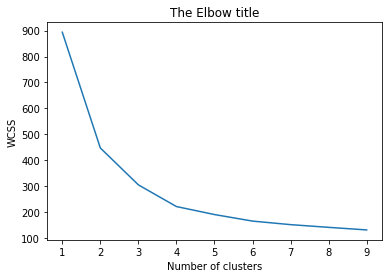

In [ ]:
#run kmeans with various number of k. evaluate no. of k based on the elbow plot

wcss=[]
max_k = 10
for i in range(1, max_k):
  kmeans = KMeans(i)
  kmeans.fit(umap_embed_comments_array)
  wcss_iter = kmeans.inertia_
  wcss.append(wcss_iter)

number_clusters = range(1, max_k)
plt.plot(number_clusters,wcss)
plt.title('The Elbow title')
plt.xlabel('Number of clusters')
plt.ylabel('WCSS')

In [ ]:
#run kmeans with no. of clusters you see fit the most

k = 10

kmeans = KMeans(n_clusters = k)
kmeans.fit(umap_embed_comments_array)

df['KMeans ID'] = kmeans.labels_

In [ ]:
#merge all reviews of each cluster into one big sentence 

df_kmeans = pd.DataFrame(columns=["KMeans ID", "texts"])


for i in range(0, k):
  row = []
  row.append(i)
  row.append(df['Review'][df['KMeans ID'] == i].to_string())
  df_kmeans.loc[len(df_kmeans)] = row

In [ ]:
df_kmeans

,KMeans ID,texts
0,0,8 \nร้านเบอเกอรี่ร้านนี้อยู่ในร้านล้างรถช...
1,1,4 ชอบมาทานร้านนี้ถ้าอยากกินอาหารเวียดนามใ...
2,2,13 เคยเป็นไหมกันไหมคะ หลังอาหารมื้อใหญ่ ต่...
3,3,3 วันนี้มีโอกาสตื่นเช้าครับเลยถึงโอกาสออก...
4,4,11 โลตัสพัฒนาการมีร้านชีทเค้กน่าหม่ำอยู่ร้...
5,5,6 สวัสดีเพื่อนๆสมาชิกนักรีวิวร้านอาหารชาว...
6,6,5 เป็นร้านที่สะดุดตาที่สุดบนถนนจรัญ เลยก็...
7,7,20 เช้าๆบ่ายๆหรือเย็นๆ อาหารว่างที่คนเรามั...
8,8,0 เป็นคนที่ชอบทาน Macchiato เป็นประจำ มีว...
9,9,2 กวงทะเลเผา อาหารทะเลเค้าสดจริงๆเนื้อปูห...


In [ ]:
#create regex compiler for removal of a character you don't want

special_characters = "/[!@#$%^&*']/g"

specialchar_pattern = re.compile(special_characters)

In [ ]:
#create regex compiler for removal of any emoji

emoji_pattern = re.compile("["
        u"\U0001F600-\U0001F64F"  # emoticons
        u"\U0001F300-\U0001F5FF"  # symbols & pictographs
        u"\U0001F680-\U0001F6FF"  # transport & map symbols
        u"\U0001F1E0-\U0001F1FF"  # flags (iOS)
                           "]+", flags=re.UNICODE)

In [ ]:
#create regex compiler for removal of digit

number_pattern = re.compile("[0-9]")

In [ ]:
#create regex compiler for removal of white space

space_pattern = re.compile("\s+")

In [ ]:
#create regex compiler for removal of .

dot_pattern = re.compile(r"\.+")

In [ ]:
#create regex compiler for removal of \

backslash_pattern = re.compile(r"\\+")

In [ ]:
#create regex compiler for removal of () []

parenthesis1_pattern = re.compile(r"\(+")
parenthesis2_pattern = re.compile(r"\)+")
bracket1_pattern = re.compile(r"\[+")
bracket2_pattern = re.compile(r"\[+")

In [ ]:
#define a function to tokenize a sentence into words - you can define words you want to remove as well as new words for tokenization

stopwords = list(pythainlp.corpus.thai_stopwords())
removed_words = ['u', 'b', 'n', 'nn', 'nn-', '\n', 'ร้าน', 'ร้านอาหาร', 'ผม', 'ดิ','ชั้น','ฉัน','ดิชั้น',',','น', '\'']
screening_words = stopwords + removed_words

new_words = {"สตารบัก"}

words = new_words.union(thai_words())

custom_dictionary_trie = Trie(words)

def tokenize_to_list(sentence):
  merged = []
  words = pythainlp.word_tokenize(str(sentence), engine='newmm', custom_dict=custom_dictionary_trie)
  for word in words:
    if word not in screening_words:
      merged.append(word)
  return merged

In [ ]:
#clean and tokenize sentences. count the occurences of each word

df_kmeans['texts'] = df_kmeans['texts'].apply(lambda x: emoji_pattern.sub(r'', x))
df_kmeans['texts'] = df_kmeans['texts'].apply(lambda x: specialchar_pattern.sub(r'', x))
df_kmeans['texts'] = df_kmeans['texts'].apply(lambda x: number_pattern.sub(r'', x))
df_kmeans['texts'] = df_kmeans['texts'].apply(lambda x: space_pattern.sub(r'', x))
df_kmeans['texts'] = df_kmeans['texts'].apply(lambda x: dot_pattern.sub(r'', x))
df_kmeans['texts'] = df_kmeans['texts'].apply(lambda x: backslash_pattern.sub(r'', x))
df_kmeans['texts'] = df_kmeans['texts'].apply(lambda x: parenthesis1_pattern.sub(r'', x))
df_kmeans['texts'] = df_kmeans['texts'].apply(lambda x: parenthesis2_pattern.sub(r'', x))
df_kmeans['texts'] = df_kmeans['texts'].apply(lambda x: bracket1_pattern.sub(r'', x))
df_kmeans['texts'] = df_kmeans['texts'].apply(lambda x: bracket2_pattern.sub(r'', x))
df_kmeans['texts_tokenized'] = df_kmeans['texts'].apply(lambda x: tokenize_to_list(x))
df_kmeans['texts_count'] = df_kmeans['texts_tokenized'].apply(lambda x: collections.Counter(x).most_common())

In [ ]:
#results of tokenization

df_kmeans

,KMeans ID,texts,texts_tokenized,texts_count
0,0,nร้านเบอเกอรี่ร้านนี้อยู่ในร้านล้างรถชื่อว่าร้...,"[เบอ, เก, อ, รี่, ล้างรถ, ชื่อว่า, ร้านกาแฟ, น...","[(กาแฟ, 9), (ร้านกาแฟ, 7), (ทาน, 4), (ดี, 4), ..."
1,1,ชอบมาทานร้านนี้ถ้าอยากกินอาหารเวียดนามใกล้บ้าน...,"[ชอบ, ทาน, กิน, อาหาร, เวียดนาม, บ้าน, กิน, เค...","[(กิน, 7), (ทาน, 4), (บ้าน, 4), (อร่อย, 4), (ร..."
2,2,เคยเป็นไหมกันไหมคะหลังอาหารมื้อใหญ่ต่อให้อิ่เป...,"[ไหม, ไหม, หลังอาหาร, มื้อ, ต่อให้, อิ่, เครื่...","[(ชา, 18), (ไข่มุก, 14), (นม, 12), (ทาน, 5), (..."
3,3,วันนี้มีโอกาสตื่นเช้าครับเลยถึงโอกาสออกมาหาอะไ...,"[มีโอกาส, ตื่น, เช้า, โอกาส, มาหา, อะ, ไร้, าน...","[(กก, 5), (เก่าแก่, 3), (ไข่, 3), (ขาย, 3), (เ..."
4,4,โลตัสพัฒนาการมีร้านชีทเค้กน่าหม่ำอยู่ร้านนึงค่...,"[โลตัส, พัฒนาการ, ชี, ท, เค้ก, หม่ำ, นึง, ค่, ...","[(ร้านกาแฟ, 8), (เบเกอรี่, 4), (ทาน, 4), (พาย,..."
5,5,สวัสดีเพื่อนๆสมาชิกนักรีวิวร้านอาหารชาวWongnaร...,"[สวัสดี, เพื่อน, สมาชิก, รีวิว, Wongna, ตกแต่ง...","[(อาหาร, 7), (อร่อย, 3), (ราคา, 3), (ทาน, 3), ..."
6,6,เป็นร้านที่สะดุดตาที่สุดบนถนนจรัญเลยก็ว่าได้สถ...,"[สะดุดตา, ถนน, จรัญ, สถาน, ที่ตั้ง, ปากซอย, สุ...","[(อร่อย, 5), (ร้านกาแฟ, 5), (กาแฟ, 5), (ชอบ, 4..."
7,7,เช้าๆบ่ายๆหรือเย็นๆอาหารว่างที่คนเรามักหยิบจัร...,"[เช้า, บ่าย, เย็น, อาหารว่าง, คนเรา, หยิบ, จัร...","[(ร้า, 2), (นม, 2), (น้ำ, 2), (ปั่น, 2), (แตงโ..."
8,8,เป็นคนที่ชอบทานMacchiatoเป็นประจำมีวันนึงเดArt...,"[คน, ชอบ, ทาน, Macchiato, เป็นประจำ, นึง, เด, ...","[(ร้านกาแฟ, 7), (กาแฟ, 5), (คน, 3), (ชอบ, 3), ..."
9,9,กวงทะเลเผาอาหารทะเลเค้าสดจริงๆเนื้อปูหวานไม่คร...,"[กวง, ทะเล, เผา, อาหารทะเล, เค้า, สด, เนื้อ, ป...","[(ส้มตำ, 3), (ส, 3), (ยำ, 3), (แซ่บ, 3), (กิน,..."


In [ ]:
#show top keywords of each cluster

top_N_words = 10

for i in range(0, len(df_kmeans)):
  print(f"Cluster ID : {i}\n")
  print(f"Most common words include : {list(df_kmeans['texts_count'][i])[:top_N_words]}\n")

#tune a model by remove unwanted characters and words and add more words to a custom dictionary

Cluster ID : 0

Most common words include : [('กาแฟ', 9), ('ร้านกาแฟ', 7), ('ทาน', 4), ('ดี', 4), ('อ', 3), ('วัง', 3), ('พัก', 3), ('อย', 3), ('จิบ', 3), ('แวะ', 3)]

Cluster ID : 1

Most common words include : [('กิน', 7), ('ทาน', 4), ('บ้าน', 4), ('อร่อย', 4), ('รีวิว', 4), ('อาหาร', 3), ('บอ', 3), ('ดี', 3), ('สาขา', 3), ('ดีล', 3)]

Cluster ID : 2

Most common words include : [('ชา', 18), ('ไข่มุก', 14), ('นม', 12), ('ทาน', 5), ('เครื่องดื่ม', 4), ('ลอง', 3), ('เดิน', 3), ('ไต้หวัน', 3), ('ไหม', 2), ('ชาเขียว', 2)]

Cluster ID : 3

Most common words include : [('กก', 5), ('เก่าแก่', 3), ('ไข่', 3), ('ขาย', 3), ('เป็ด', 3), ('ไร้', 2), ('าน', 2), ('ข้าวห่อ', 2), ('เมนู', 2), ('เก', 2)]

Cluster ID : 4

Most common words include : [('ร้านกาแฟ', 8), ('เบเกอรี่', 4), ('ทาน', 4), ('พาย', 4), ('คาเฟ่', 4), ('เค้ก', 3), ('แนว', 3), ('กาแฟ', 3), ('ชอบ', 3), ('กา', 2)]

Cluster ID : 5

Most common words include : [('อาหาร', 7), ('อร่อย', 3), ('ราคา', 3), ('ทาน', 3), ('ซอย', 3), ('กาแฟ', 3)

**Step 3 - document clustering using Agglomorative Clustering with cosine similarity**

In [ ]:
#clustering using agglomorative clustering

knn_graph = kneighbors_graph(embed_comments_array, 5, include_self=False)
model = AgglomerativeClustering(linkage="average", connectivity=knn_graph, n_clusters=10, affinity="cosine")
model.fit(embed_comments_array)
df['Agglomerative ID'] = model.labels_

In [ ]:
#merge all reviews of each cluster into one big sentence 

df_Agglomerative = pd.DataFrame(columns=["Agglomerative ID", "texts"])


for i in range(0, k):
  row = []
  row.append(i)
  row.append(str(df['Review'][df['Agglomerative ID'] == i].tolist()))
  df_Agglomerative.loc[len(df_Agglomerative)] = row

In [ ]:
#clean and tokenize sentences. count the occurences of each word

df_Agglomerative['texts'] = df_Agglomerative['texts'].apply(lambda x: emoji_pattern.sub(r'', x))
df_Agglomerative['texts'] = df_Agglomerative['texts'].apply(lambda x: specialchar_pattern.sub(r'', x))
df_Agglomerative['texts'] = df_Agglomerative['texts'].apply(lambda x: number_pattern.sub(r'', x))
df_Agglomerative['texts'] = df_Agglomerative['texts'].apply(lambda x: space_pattern.sub(r'', x))
df_Agglomerative['texts'] = df_Agglomerative['texts'].apply(lambda x: dot_pattern.sub(r'', x))
df_Agglomerative['texts'] = df_Agglomerative['texts'].apply(lambda x: backslash_pattern.sub(r'', x))
df_Agglomerative['texts'] = df_Agglomerative['texts'].apply(lambda x: parenthesis1_pattern.sub(r'', x))
df_Agglomerative['texts'] = df_Agglomerative['texts'].apply(lambda x: parenthesis2_pattern.sub(r'', x))
df_Agglomerative['texts'] = df_Agglomerative['texts'].apply(lambda x: bracket1_pattern.sub(r'', x))
df_Agglomerative['texts'] = df_Agglomerative['texts'].apply(lambda x: bracket2_pattern.sub(r'', x))
df_Agglomerative['texts_tokenized'] = df_Agglomerative['texts'].apply(lambda x: tokenize_to_list(x))
df_Agglomerative['texts_count'] = df_Agglomerative['texts_tokenized'].apply(lambda x: collections.Counter(x).most_common())

In [ ]:
#show top keywords of each cluster

top_N_words = 10

for i in range(0, len(df_Agglomerative)):
  print(f"Cluster ID : {i}\n")
  print(f"Most common words include : {list(df_Agglomerative['texts_count'][i])[:top_N_words]}\n")

Cluster ID : 0

Most common words include : [('อร่อย', 508), ('ทาน', 416), ('รสชาติ', 407), ('ดี', 347), ('กิน', 339), ('กาแฟ', 312), ('เมนู', 309), ('สั่ง', 301), ('อาหาร', 285), ('ราคา', 273)]

Cluster ID : 1

Most common words include : [('แตงโม', 22), ('น้ำ', 8), ('ปั่น', 6), ('เนื้อ', 6), ('เลือก', 4), ('ซื้อ', 4), ('ดื่ม', 4), ('พันธุ์', 3), ('รับประทาน', 3), ('แก้', 3)]

Cluster ID : 2

Most common words include : [('แย่มาก', 3), ('โต๊ะ', 2), ('รอง', 2), ('แก้ว', 2), ('ช้ัน', 1), ('ทบ', 1), ('อาหาร', 1), ('เวลา', 1), ('โมง', 1), ('เย็น', 1)]

Cluster ID : 3

Most common words include : [('นม', 3), ('แน่น', 2), ('tamp', 2), ('เท', 2), ('แก้', 2), ('เรื่อง', 1), ('ขนม', 1), ('สันทัด', 1), ('ดังนั้น', 1), ('review', 1)]

Cluster ID : 4

Most common words include : [('ซอย', 2), ('สถาน', 1), ('ที่ตั้ง', 1), ('ปากซอย', 1), ('สุขุมวิท', 1), ('บริเวณ', 1), ('ซ้ายมือ', 1), ('ที่นั่ง', 1), ('นั่ง', 1), ('คนอื่น', 1)]

Cluster ID : 5

Most common words include : [('ปัง', 4), ('ภูเขาไฟ', 3)

**Step 4 - result discussion**

**การเปลี่ยนแปลงครั้งที่ 1**

เปลี่ยน top_N_words = 10 เป็น 20 เพื่อวิเคราะห์ให้เห็นภาพรวมของคำในแต่ละกลุ่มมากขึ้น เมื่อวิเคราะห์จากการเปลี่ยนแปลงในครั้งนี้ 

กลุ่มที่ 0 จะเห็นคำว่า "ชอบ" "ชา" เพิ่มเติมประกอบกับ 10 อันดับแรกก็จะเห็นว่าเครื่องดื่มและอาหารนั้นมีความคิดเห็นในทางบวก น่าจะเป็นกลุ่มรีวิวที่มีความคิดเห็นในทางที่ดีกับสินค้าและบริการของทางร้านอาหารต่างๆ

กลุ่มที่ 1 จะเห็นว่าเป็นกลุ่มที่อธิบายสรรพคุณของอาหารที่เกี่ยวข้องกับร่างกาย

กลุ่มที่ 2 คำหลังนั้นจากอันดับ 10 แรกที่น่าจะเป้นความคิดเห็นทางลบนั้น ก็ไม่ได้ช่วยเพิ่มเติมไอเดียมาก กลุ่มนี้น่าจะมีคำน้อยเมื่อเทียบกับกลุ่มอื่น

กลุ่มที่ 3 การดูผลจากข้อนี้ยังไม่ได้ภาพรวมที่เพิ่มเติมมากเท่าไร 

สรุปผลการเปลี่ยนแปลงคือคำส่วนมากจะไปกระจุกอยู่กลุ่มที่ 0 ทำให้กลุ่มอื่นๆดูไม่ค่อยมีความเชื่อมโยงหรือความสัมพันธ์ที่ชัดเจนมากข้อเพราะฉะนั้นจะลองปรับจำนวนกลุ่มลดลงให้เหลือ 3 กลุ่มในการเปลี่ยนแปลงครั้งที่ 2

**การเปลี่ยนแปลงครั้งที่ 2**

เปลี่่ยน Kmean จาก 4 เป็น 3 กลุ่ม
ผลลัพธ์ที่ออกมาก็ยังใกล้เคียงการเปลี่ยนแปลงครั้งที่ 1 ในแต่ละกลุ่มยังมีคำที่สะท้อนกลุ่มเหมือนเดิม

**การเปลี่ยนแปลงครั้งที่ 3**

เพิ่มโค้ดเพิ่มลบวงเล็บ () [] ออกจากคำที่นับออกมาผลก็ไม่ได้เปลี่ยนแปลง

**การเปลี่ยนแปลงครั้งที่ 4**

เพิ่ม stopword ที่เป็นสรรพนามออกเพิ่มเติม 'ร้านอาหาร', 'ผม', 'ดิ','ชั้น','ฉัน','ดิชั้น',',','น' ผลของการเปลี่ยนแปลงก็ไม่มีอะไรเปลี่ยนแปลง

**การเปลี่ยนแปลงครั้งที่ 5**

ลองเปลี่ยน n_component จาก 50 เป็น 100 ไม่มีการเปลี่ยนแปลงผลลัพธ์

ลองเปลี่ยน n_component จาก 50 เป็น 20 ไม่มีการเปลี่ยนแปลงผลลัพธ์

**การเปลี่ยนแปลงครั้งที่ 6**

เปลี่่ยน Kmean จาก 3 เป็น 2 กลุ่ม
ผลลัพธ์ที่ออกมาก็ยังใกล้เคียงการเปลี่ยนแปลงครั้งที่ 1 ในแต่ละกลุ่มยังมีคำที่สะท้อนกลุ่มเหมือนเดิม

**การเปลี่ยนแปลงครั้งที่ 7**

เปลี่่ยน Kmean จาก 2 เป็น 10 กลุ่ม
ผลลัพธ์ที่ออกมาก็ยังใกล้เคียงการเปลี่ยนแปลงครั้งที่ 1 ใน 3 กลุ่มแรก (กลุ่ม 0 ถึง 2) ในกลุ่มย่อยที่ตามมาก็ยังไม่มีความชัดเจนเท่าไร ความพยายามในการแยกกลุ่ม 1 ให้ย่อยมาไม่สำเร็จ